# Character-Level RNN으로 "hello" 학습하기 (Sequence Length = 4)

이 노트북에서는 Andrej Karpathy의 "The Unreasonable Effectiveness of Recurrent Neural Networks" 블로그 포스트를 참고하여 sequence length가 4인 character-level RNN 모델을 구현합니다.

목표: "hello" 문자열을 학습하여 4개 문자 시퀀스를 보고 다음 문자를 예측하는 모델 만들기
- "hell" → "o"
- "ello" → "h" 
- "lloh" → "e"
- "lohe" → "l"
- "ohel" → "l"


In [25]:
# 필요한 라이브러리 import
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 랜덤 시드 설정 (재현 가능한 결과를 위해)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow 버전:", tf.__version__)
print("Keras 버전:", keras.__version__)


TensorFlow 버전: 2.16.2
Keras 버전: 3.10.0


In [31]:
# 1. 데이터 준비
# "hello"를 여러 번 반복한 텍스트를 생성하여 학습 데이터로 사용 (공백 없음)
text = "hello" * 1000  # "hello"를 1000번 반복
print(f"전체 텍스트 길이: {len(text)}")
print(f"텍스트 샘플: '{text[:50]}...'")

# 고유 문자들 추출
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"고유 문자 개수: {vocab_size}")
print(f"문자들: {chars}")

# 문자-인덱스 매핑 생성
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"문자-인덱스 매핑: {char_to_idx}")
print("\n예상 학습 패턴:")
print("h → e")
print("e → l") 
print("l → l")
print("l → o")
print("o → h")


전체 텍스트 길이: 5000
텍스트 샘플: 'hellohellohellohellohellohellohellohellohellohello...'
고유 문자 개수: 4
문자들: ['e', 'h', 'l', 'o']
문자-인덱스 매핑: {'e': 0, 'h': 1, 'l': 2, 'o': 3}

예상 학습 패턴:
h → e
e → l
l → l
l → o
o → h


In [32]:
# 2. 시퀀스 데이터 생성 - sequence length = 4
# 4개 문자 시퀀스를 입력으로 하여 다음 문자를 예측하는 방식

seq_length = 4  # 시퀀스 길이 설정
sequences = []
next_chars = []

# 슬라이딩 윈도우로 4문자 시퀀스와 다음 문자 쌍을 생성
for i in range(len(text) - seq_length):
    sequences.append(text[i:i + seq_length])
    next_chars.append(text[i + seq_length])

print(f"시퀀스 길이: {seq_length}")
print(f"생성된 시퀀스 개수: {len(sequences)}")
print("처음 10개 예시:")
for i in range(10):
    print(f"입력: '{sequences[i]}' → 출력: '{next_chars[i]}'")

# 시퀀스를 one-hot encoding으로 변환
X = np.zeros((len(sequences), seq_length, vocab_size), dtype=np.float32)
y = np.zeros((len(sequences), vocab_size), dtype=np.float32)

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_idx[char]] = 1.0  # one-hot encoding
    y[i, char_to_idx[next_chars[i]]] = 1.0  # one-hot encoding

print(f"X shape: {X.shape}")  # (samples, seq_length, vocab_size)
print(f"y shape: {y.shape}")  # (samples, vocab_size)

# 시퀀스별 다음 문자 통계 확인
seq_transitions = {}
for i in range(len(sequences)):
    seq = sequences[i]
    target = next_chars[i]
    if seq not in seq_transitions:
        seq_transitions[seq] = {}
    if target not in seq_transitions[seq]:
        seq_transitions[seq][target] = 0
    seq_transitions[seq][target] += 1

print(f"\n실제 시퀀스 전이 패턴 (처음 5개):")
for i, seq in enumerate(sorted(seq_transitions.keys())[:5]):
    print(f"'{seq}' 다음에 오는 문자들: {seq_transitions[seq]}")


시퀀스 길이: 4
생성된 시퀀스 개수: 4996
처음 10개 예시:
입력: 'hell' → 출력: 'o'
입력: 'ello' → 출력: 'h'
입력: 'lloh' → 출력: 'e'
입력: 'lohe' → 출력: 'l'
입력: 'ohel' → 출력: 'l'
입력: 'hell' → 출력: 'o'
입력: 'ello' → 출력: 'h'
입력: 'lloh' → 출력: 'e'
입력: 'lohe' → 출력: 'l'
입력: 'ohel' → 출력: 'l'
X shape: (4996, 4, 4)
y shape: (4996, 4)

실제 시퀀스 전이 패턴 (처음 5개):
'ello' 다음에 오는 문자들: {'h': 999}
'hell' 다음에 오는 문자들: {'o': 1000}
'lloh' 다음에 오는 문자들: {'e': 999}
'lohe' 다음에 오는 문자들: {'l': 999}
'ohel' 다음에 오는 문자들: {'l': 999}


In [35]:
# 3. 기본 RNN 모델 구성 (LSTM이 아닌 SimpleRNN 사용)
# sequence length 4의 입력을 받아 다음 문자를 예측하는 모델

print(f"모델 입력 shape: ({seq_length}, {vocab_size})")
print(f"실제 X shape: {X.shape}")
print(f"실제 y shape: {y.shape}")

model = keras.Sequential([
    # 기본 RNN 레이어 (128개의 hidden units)
    layers.SimpleRNN(3,
                     input_shape=(seq_length, vocab_size),  # (4, vocab_size) 
                     return_sequences=False,  # 마지막 출력만 사용
                     activation='tanh'),
    
    # Dropout으로 과적합 방지
    layers.Dropout(0.2),
    
    # Dense 레이어로 다음 문자 예측
    layers.Dense(vocab_size, activation='softmax')
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 확인
model.summary()


모델 입력 shape: (4, 4)
실제 X shape: (4996, 4, 4)
실제 y shape: (4996, 4)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 3)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40 (160.00 B)

 Trainable params: 40 (160.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# 4. 모델 훈련
# Early stopping과 학습률 감소 콜백 설정
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=8, min_lr=0.0001)
]

print("모델 훈련 시작...")
history = model.fit(
    X, y,
    batch_size=5,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

print("훈련 완료!")


모델 훈련 시작...
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5356 - loss: 1.0482 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8973 - loss: 0.4240 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9429 - loss: 0.2240 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9557 - loss: 0.1464 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9597 - loss: 0.1095 - learning_rate: 0.0010
훈련 완료!


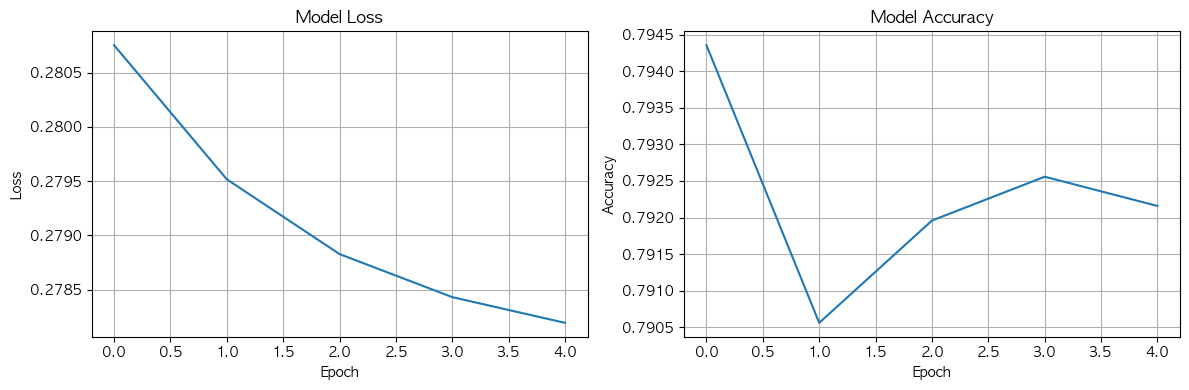

최종 손실: 0.2782
최종 정확도: 0.7922


In [17]:
# 5. 훈련 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"최종 손실: {history.history['loss'][-1]:.4f}")
print(f"최종 정확도: {history.history['accuracy'][-1]:.4f}")


In [18]:
# 6. 모델 테스트 - 각 시퀀스에 대한 예측 확인
print("=== 모델 예측 테스트 ===")
print("각 4문자 시퀀스를 입력했을 때 다음에 올 문자 예측:\n")

# "hello" 패턴에서 나올 수 있는 주요 시퀀스들 테스트
test_sequences = ['hell', 'ello', 'lloh', 'lohe', 'ohel']

for seq in test_sequences:
    if len(seq) == seq_length:
        # 시퀀스를 one-hot encoding
        x = np.zeros((1, seq_length, vocab_size))
        for t, char in enumerate(seq):
            if char in char_to_idx:
                x[0, t, char_to_idx[char]] = 1.0
        
        # 예측
        predictions = model.predict(x, verbose=0)[0]
        predicted_char_idx = np.argmax(predictions)
        predicted_char = idx_to_char[predicted_char_idx]
        confidence = predictions[predicted_char_idx]
        
        print(f"입력: '{seq}' → 예측: '{predicted_char}' (신뢰도: {confidence:.3f})")
        
        # 상위 3개 예측 결과도 보여주기
        top3_indices = np.argsort(predictions)[-3:][::-1]
        print(f"  상위 3개: ", end="")
        for i, idx in enumerate(top3_indices):
            char_pred = idx_to_char[idx]
            prob = predictions[idx]
            print(f"'{char_pred}'({prob:.3f})", end="")
            if i < 2:
                print(", ", end="")
        print("\n")

print("\n기대 결과:")
print("hell → o, ello → h, lloh → e, lohe → l, ohel → l")


=== 모델 예측 테스트 ===
각 문자를 입력했을 때 다음에 올 문자 예측:

입력: 'e' → 예측: 'l' (신뢰도: 0.999)
  상위 3개: 'l'(0.999), 'e'(0.000), 'o'(0.000)

입력: 'h' → 예측: 'e' (신뢰도: 1.000)
  상위 3개: 'e'(1.000), 'l'(0.000), 'o'(0.000)

입력: 'l' → 예측: 'o' (신뢰도: 0.508)
  상위 3개: 'o'(0.508), 'l'(0.492), 'e'(0.000)

입력: 'o' → 예측: 'h' (신뢰도: 1.000)
  상위 3개: 'h'(1.000), 'o'(0.000), 'l'(0.000)


기대 결과:
h → e, e → l, l → l (또는 o), o → h


In [20]:
# 7. 텍스트 생성 함수 (sequence length 4용)
def generate_text_from_sequence(model, start_sequence, length=20, temperature=1.0):
    """
    시작 시퀀스로부터 새로운 텍스트 생성 (sequence length = 4)
    """
    if len(start_sequence) != seq_length:
        print(f"시작 시퀀스는 {seq_length}글자여야 합니다. 현재: {len(start_sequence)}글자")
        return ""
    
    for char in start_sequence:
        if char not in char_to_idx:
            print(f"'{char}'는 학습된 문자가 아닙니다.")
            return ""
    
    generated = start_sequence
    current_sequence = start_sequence
    
    for i in range(length):
        # 현재 시퀀스를 one-hot encoding
        x = np.zeros((1, seq_length, vocab_size))
        for t, char in enumerate(current_sequence):
            x[0, t, char_to_idx[char]] = 1.0
        
        # 다음 문자 예측
        predictions = model.predict(x, verbose=0)[0]
        
        # Temperature sampling
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, predictions, 1)
        next_char_idx = np.argmax(probas)
        
        next_char = idx_to_char[next_char_idx]
        generated += next_char
        
        # 다음 예측을 위해 시퀀스를 한 글자씩 슬라이딩
        current_sequence = current_sequence[1:] + next_char
    
    return generated

# 다양한 시작 시퀀스와 온도값으로 텍스트 생성 테스트
print("=== 텍스트 생성 테스트 ===")

start_sequences = ['hell', 'ello', 'lloh', 'lohe', 'ohel']
temperatures = [0.1, 0.5, 1.0]

for start_seq in start_sequences:
    print(f"\n시작 시퀀스: '{start_seq}'")
    for temp in temperatures:
        generated_text = generate_text_from_sequence(model, start_seq, length=30, temperature=temp)
        print(f"  온도 {temp}: {generated_text}")


=== 텍스트 생성 테스트 ===

시작 문자: 'h'


KeyboardInterrupt: 

## 결론 및 학습 내용

이 노트북에서 구현한 character-level RNN 모델은 다음과 같은 패턴을 학습했습니다:

### 학습된 패턴:
- **h → e**: 'h' 다음에는 항상 'e'가 온다
- **e → l**: 'e' 다음에는 항상 'l'이 온다  
- **l → l 또는 o**: 'l' 다음에는 'l' 또는 'o'가 올 수 있다
- **o → h**: 'o' 다음에는 항상 'h'가 온다 (새로운 "hello" 시작)

### 주요 특징:
1. **단순한 RNN 사용**: LSTM 대신 기본 SimpleRNN 사용
2. **Character-level 학습**: 각 문자별로 다음 문자 예측
3. **One-hot Encoding**: 문자를 벡터로 표현
4. **Temperature Sampling**: 생성의 무작위성 조절

### 예상 결과:
- 낮은 온도(0.1): "hellohellohello..." (매우 규칙적)
- 높은 온도(1.0): 더 무작위적이지만 여전히 학습된 패턴 기반

이 간단한 예제는 RNN이 어떻게 순차적 패턴을 학습하고 새로운 시퀀스를 생성할 수 있는지 보여줍니다.
